# Cutting stock problem with column generation

## Restricted master problem

$$
\begin{align}
    \text{min} \quad & \sum_{p \in P} c_{p} x_{p} \\
    \text{s.t} \quad & d_{i} \leq \sum_{p \in P} a_{i, p} x_{p} & \forall \; i \in I \\
    & x_{p} \geq 0 & \forall \; p \in P \\
    & x_{p} \in \mathbb{Z} & \forall \; p \in P
\end{align}
$$

## Pricing problem

$$
\begin{align}
    \text{max} \quad & \sum_{i \in I} \pi_{i} y_{i} \\
    \text{s.t} \quad & \sum_{i \in I} w_{i} y_{i} \leq W\\
    & y_{i} \geq 0 & \forall \; i \in I \\
    & y_{i} \in \mathbb{Z} & \forall \; i \in I
\end{align}
$$

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv("data.txt", sep=" ")
print(dataset.head())

      w   d
0  75.0  38
1  71.3  44
2  67.0  30
3  61.4  41
4  58.0  36


In [3]:
def solve_knapsack(W, w, duals):
    return linprog(-duals, A_ub=np.atleast_2d(w), b_ub=np.atleast_1d(W), bounds=(0, np.inf), integrality=1)

In [4]:
# Total width
W = 100.0

# Width and amount associated with each demand
w = dataset.w.values
d = dataset.d.values

# LP parameters
A = np.eye(dataset.shape[0]) * (W // w)
c = np.ones_like(w)

# Initial solution
sol = linprog(c, A_ub=-A, b_ub=-d, bounds=(0, None))
sol_dual = linprog(-d, A_ub=A.T, b_ub=c, bounds=(0, None))
diff = np.abs(sol_dual.x + sol.ineqlin.marginals).sum()
print(f"Compare duality difference: {diff}")

# Iterate
for _ in range(1000):
    duals = -sol.ineqlin.marginals
    price_sol = solve_knapsack(W, w, duals)
    y = price_sol.x
    if 1 + price_sol.fun < -1e-4:
        print(f"Iteration: {_}; Reduced cost: {(1 + price_sol.fun):.3f}")
        A = np.hstack((A, y.reshape((-1, 1))))
        c = np.append(c, 1)
        sol = linprog(c, A_ub=-A, b_ub=-d, bounds=(0, None))
    else:
        break

sol_round = linprog(c, A_ub=-A, b_ub=-d, bounds=(0, np.inf), integrality=0)
print(f"Rounding solution {np.ceil(sol_round.x).sum()}")
sol = linprog(c, A_ub=-A, b_ub=-d, bounds=(0, np.inf), integrality=1)
print(f"Integer solution: {sol.x.sum()}")

Compare duality difference: 0.0
Iteration: 0; Reduced cost: -0.591
Iteration: 1; Reduced cost: -0.535
Iteration: 2; Reduced cost: -0.533
Iteration: 3; Reduced cost: -0.500
Iteration: 4; Reduced cost: -0.515
Iteration: 5; Reduced cost: -0.500
Iteration: 6; Reduced cost: -0.511
Iteration: 7; Reduced cost: -0.500
Iteration: 8; Reduced cost: -0.400
Iteration: 9; Reduced cost: -0.413
Iteration: 10; Reduced cost: -0.433
Iteration: 11; Reduced cost: -0.333
Rounding solution 339.0
Integer solution: 334.0


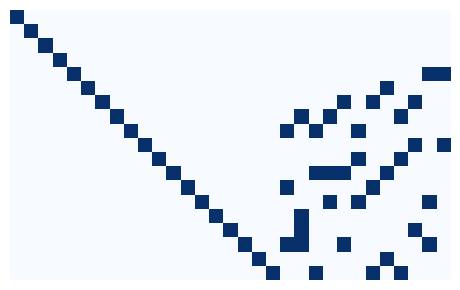

In [5]:
fig, ax = plt.subplots(figsize=[7, 3], dpi=100)
hmap = ax.imshow(A > 1e-6, cmap="Blues")
plt.axis('off')
fig.tight_layout()
plt.show()